# LightGBM（特徴量：ALL）の学習→予測→評価

In [ ]:
# # Colabでバージョンを変更するとき、コメントアウトして実行してください
# !pip install pandas==2.0.3
# !pip install numpy==1.25.2
# !pip install matplotlib==3.7.1
# !pip install scikit-learn==1.2.2
# !pip install lightgbm==4.1.0

In [1]:
# ライブラリのインポート
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
# バージョンの確認
import matplotlib
import sklearn
import lightgbm as lgb
print(pd.__version__)
print(np.__version__)
print(matplotlib.__version__)
print(sklearn.__version__)
print(lgb.__version__)

2.0.3
1.25.2
3.7.1
1.2.2
4.1.0


In [3]:
# データセットの読み込み
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data', header=None, sep='\s+')
df.columns=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
#df.head()

In [4]:
# 特徴量と目的変数の設定
X = df.drop(['MEDV'], axis=1)
y = df['MEDV']

In [5]:
# 学習データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)
print('X_trainの形状：', X_train.shape, ' y_trainの形状：', y_train.shape, ' X_testの形状：', X_test.shape, ' y_testの形状：', y_test.shape)

X_trainの形状： (404, 13)  y_trainの形状： (404,)  X_testの形状： (102, 13)  y_testの形状： (102,)


In [6]:
# 学習データの20%を検証データに分割
X_tr, X_va, y_tr, y_va = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=0)
print('X_trの形状：', X_tr.shape, ' y_trの形状：', y_tr.shape, ' X_vaの形状：', X_va.shape, ' y_vaの形状：', y_va.shape)

X_trの形状： (323, 13)  y_trの形状： (323,)  X_vaの形状： (81, 13)  y_vaの形状： (81,)


In [9]:
# ハイパーパラメータの設定
import lightgbm as lgb

lgb_train = lgb.Dataset(X_tr, y_tr)
lgb_eval = lgb.Dataset(X_va, y_va, reference=lgb_train)

params = {
    'objective': 'mse',
    'metric': 'mse',
    'num_leaves': 5,
    'seed': 0,
    'verbose': -1,
}

# 誤差プロットの格納用データ
evals_result = {}

In [10]:
# モデルの学習
model = lgb.train(params,
                  lgb_train,
                  num_boost_round=500,
                  valid_sets=[lgb_train, lgb_eval],
                  valid_names=['train', 'valid'],
                  callbacks=[lgb.early_stopping(10),
                             lgb.log_evaluation(10),
                             lgb.record_evaluation(evals_result)])

Training until validation scores don't improve for 10 rounds
[10]	train's l2: 23.2219	valid's l2: 25.3721
[20]	train's l2: 11.1653	valid's l2: 14.6887
[30]	train's l2: 7.95971	valid's l2: 12.4075
[40]	train's l2: 6.6502	valid's l2: 11.5695
[50]	train's l2: 5.78035	valid's l2: 10.7954
[60]	train's l2: 5.10951	valid's l2: 10.5733
[70]	train's l2: 4.58895	valid's l2: 10.4507
[80]	train's l2: 4.17007	valid's l2: 10.1857
[90]	train's l2: 3.83847	valid's l2: 10.1489
[100]	train's l2: 3.55005	valid's l2: 9.82721
[110]	train's l2: 3.30395	valid's l2: 9.65238
[120]	train's l2: 3.09475	valid's l2: 9.56286
[130]	train's l2: 2.90294	valid's l2: 9.50011
[140]	train's l2: 2.73737	valid's l2: 9.41297
[150]	train's l2: 2.60054	valid's l2: 9.22047
[160]	train's l2: 2.45752	valid's l2: 9.17858
[170]	train's l2: 2.33145	valid's l2: 9.08158
[180]	train's l2: 2.22443	valid's l2: 8.95635
[190]	train's l2: 2.12103	valid's l2: 8.97769
Early stopping, best iteration is:
[183]	train's l2: 2.19238	valid's l2: 8.

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='l2'>

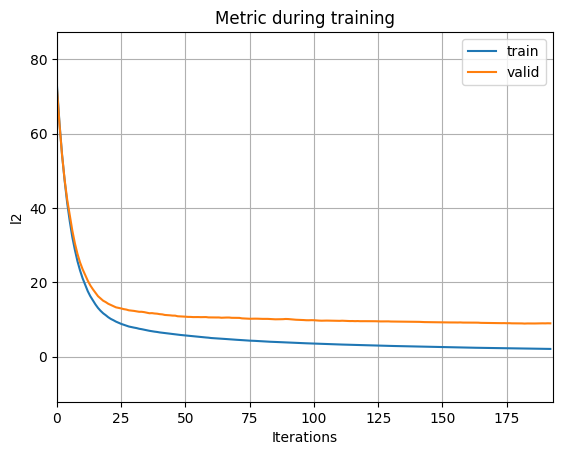

In [11]:
# 学習データと検証データの誤差プロット
lgb.plot_metric(evals_result)

In [12]:
# 学習が停止したブースティング回数
model.best_iteration

183

In [13]:
# 学習データの予測と評価
y_tr_pred = model.predict(X_tr)
print('MSE train: %.2f' % (mean_squared_error(y_tr, y_tr_pred)))
print('RMSE train: %.2f' % (mean_squared_error(y_tr, y_tr_pred) ** 0.5))

MSE train: 2.19
RMSE train: 1.48


In [14]:
# 検証データの予測と評価
y_va_pred = model.predict(X_va)
print('MSE valid: %.2f' % (mean_squared_error(y_va, y_va_pred)))
print('RMSE valid: %.2f' % (mean_squared_error(y_va, y_va_pred) ** 0.5))

MSE valid: 8.91
RMSE valid: 2.98


In [15]:
# テストデータの予測と評価
y_test_pred = model.predict(X_test)
print('RMSE test: %.2f' % (mean_squared_error(y_test, y_test_pred) ** 0.5))

RMSE test: 4.91


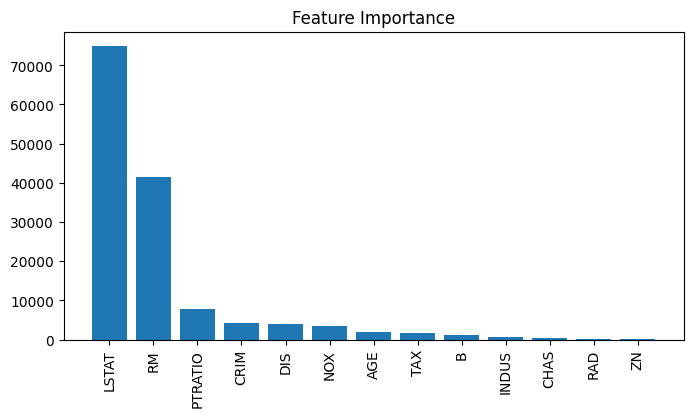

In [16]:
# 特徴量の重要度の可視化
importances = model.feature_importance(importance_type='gain') # 特徴量の重要度
indices = np.argsort(importances)[::-1] # 特徴量の重要度を降順にソート

plt.figure(figsize=(8, 4)) #プロットのサイズ指定
plt.title('Feature Importance') # プロットのタイトルを作成
plt.bar(range(len(indices)), importances[indices]) # 棒グラフを追加
plt.xticks(range(len(indices)), X.columns[indices], rotation=90) # X軸に特徴量の名前を追加
plt.show() # プロットを表示

<Axes: >

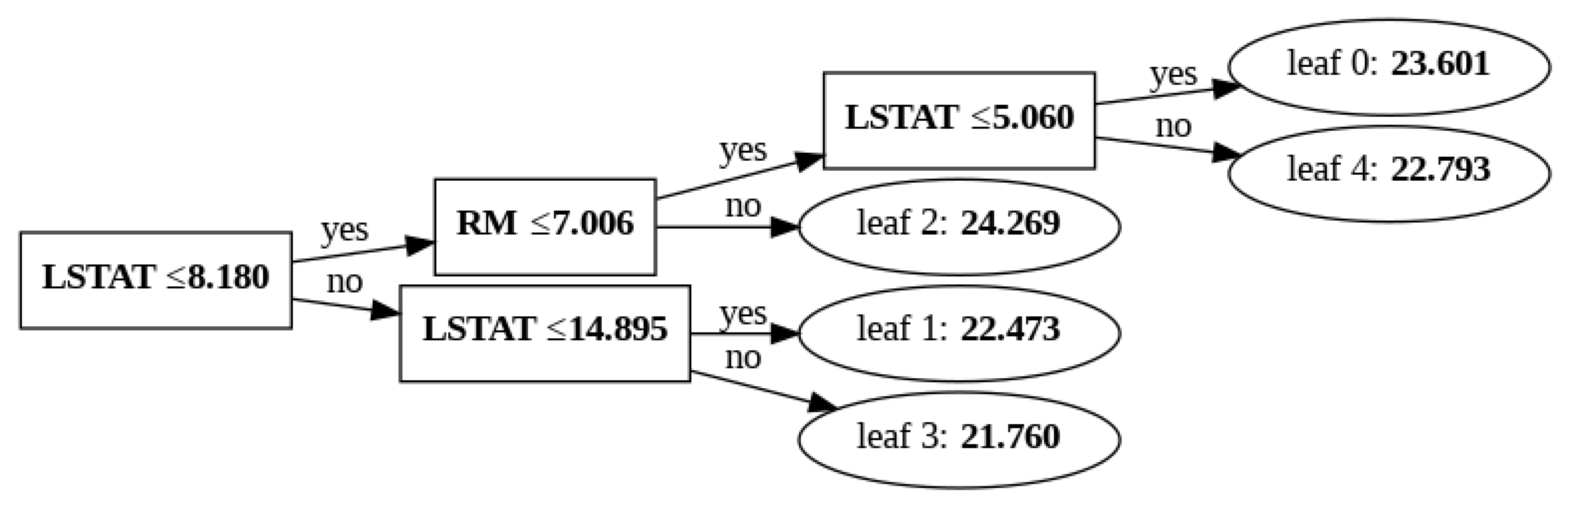

In [17]:
# 1本目の木の可視化
lgb.plot_tree(model, tree_index=0, figsize=(20, 20))

<Axes: >

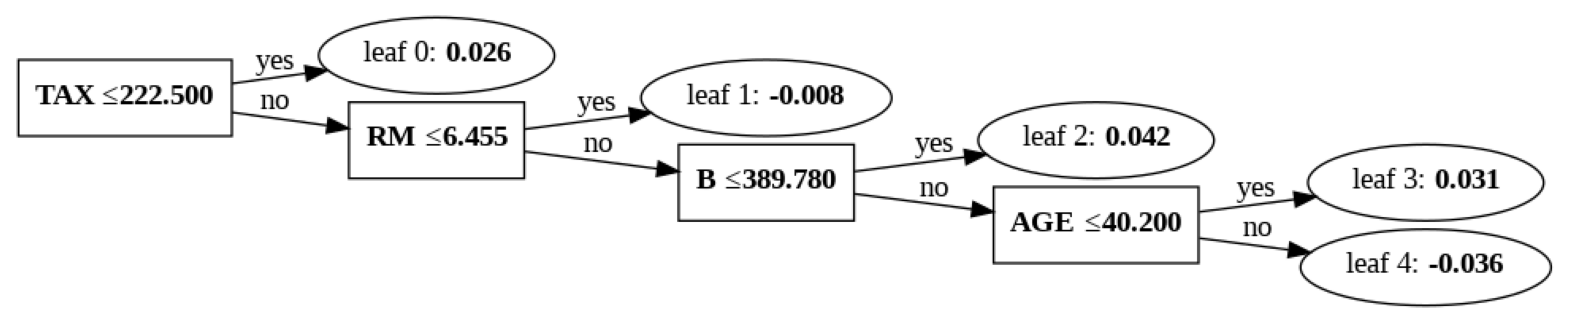

In [18]:
# 最後の木の可視化
lgb.plot_tree(model, tree_index=-1, figsize=(20, 20))